In [13]:
from slda.topic_models import SLDA
from functools import partial
from sklearn.metrics import (mean_squared_error)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import fnmatch
import re
import random
from scipy import sparse
import string

def vectorize(df):
    nFeatures=1000
    tf_vectorizer = CountVectorizer(max_df=0.90, min_df=0.1,
                                max_features=nFeatures,
                                stop_words='english')
    tf = tf_vectorizer.fit_transform(df)
    features = tf_vectorizer.get_feature_names()
    return (tf, features)

def sldaPred(model, wordMat, d, sampler):
    lglk=model.loglikelihoods[sampler:].mean()
    eta_pred = model.eta[sampler:].mean(axis=0)

    thetas_test_slda = model.transform(wordMat)
    y_slda = [np.dot(eta_pred, thetas_test_slda[i]) for i in range(d)]
    return (y_slda, lglk)

def runSLDA(df, wordMat, features, mu, mu2, sigma2, n_iter):
    print('Number of inputs:', len(df))
    scr=df['GameSpotScore']
    scr=list(scr)
    scr=np.array(scr)

    K=20
    D=len(df)
    V=len(features)
    nu2 = 10
    sigma2 = 1

    alpha = np.ones(K)
    np.random.seed(42)
    np.random.seed(42)

    _K = K
    _alpha = alpha
    _beta = np.repeat(0.01, V)
    _mu = 0
    _nu2 = nu2
    _sigma2 = sigma2
    n_iter = 200
    slda = SLDA(_K, _alpha, _beta, _mu, _nu2, _sigma2, n_iter)
    slda.fit(wordMat, scr)
    
    res={}
    res['model']=slda
    res['wordMat']=wordMat
    res['features']=features
    return res

def subWordMatrix(wordMat, indices):
    subWordMat=np.empty((0, np.shape(wordMat)[1]))
    for index in indices:
        vec=wordMat[index]
        subWordMat=np.append(subWordMat, vec, axis=0)
    return subWordMat

def calcRMSE(A,B):
    sse=0
    n=len(A)
    for a, b in zip(A, B):
        sse+=(a-b)**2
    rmse=(sse/n)**2
    return rmse

def printTopWords(slda):
    for topic in slda['model'].phi:
        topProbs=sorted(topic, reverse=True)[:10]
        indices=[]
        topWords=[]
        for prob in topProbs:
            i=np.where(topic==prob)
            for index in i[0]:
                indices.append(int(index))
            indices=indices[:10]
        for i in indices:
            topWords.append(features[i])
        print(topWords)

### Constructing pandas dataframe with ~4000 game reviews

In [39]:
df=pd.DataFrame(columns=['Name', 'Publisher', 'GameSpotScore', 'Review', 'Console', 'Genre'])

i=0
for dirpath, dirs, files in os.walk('dataset/reviews'):   
    for file in fnmatch.filter(files, '*.txt'):
        with open(os.path.join(dirpath, file), 'r') as ip:
            data=ip.read()
            name=re.findall(r':::Game Name:::(.*?)-----', data, re.DOTALL)[0].strip()
            review=re.findall(r':::Review:::(.*?)-----',data, re.DOTALL)[0].strip()
            review = review.lower()
            tVar = str.maketrans('', '', string.punctuation)
            review = review.translate(tVar)
            scores=re.findall(r':::Scores:::(.*?)-----',data, re.DOTALL)[0]
            addition=re.findall(r':::Addition:::(.*?)-----',data, re.DOTALL)[0]
            gsScore=re.findall(r'GameSpot Score:(.*?)\n', scores)[0]
#             gsScore=round(float(gsScore), 0)
            try:
                pub=re.findall(r'Publisher:(.*?)\n', addition)[0]
            except:
                pub=''
            try:
                genre=re.findall(r'Genre:(.*?)\n', addition)[0]
            except:
                genre=''
            console=dirpath.strip('dataset/reviews/')
            df.loc[i]=[name, pub, gsScore, review, console, genre]
            i+=1

### Performing supervised LDA on dataset with 200 iterations

In [40]:
df['GameSpotScore'] =pd.to_numeric(df['GameSpotScore'])

mu=0
mu2=10
sigma2=1
n_iter=200
wordMat, features=vectorize(df['Review'])
slda=runSLDA(df, wordMat, features, mu, mu2, sigma2, n_iter)

Number of inputs: 4303
2017-04-16 01:35:13.971966 start iterations
2017-04-16 01:35:30.422805 0:00:16.450839 elapsed, iter   10, LL -3973202.0304, 21.48% change from last
2017-04-16 01:35:45.817208 0:00:31.845242 elapsed, iter   20, LL -3410575.4868, 14.16% change from last
2017-04-16 01:36:01.266815 0:00:47.294849 elapsed, iter   30, LL -3209251.0953, 5.90% change from last
2017-04-16 01:36:16.542857 0:01:02.570891 elapsed, iter   40, LL -3099660.2507, 3.41% change from last
2017-04-16 01:36:31.901383 0:01:17.929417 elapsed, iter   50, LL -3031133.2266, 2.21% change from last
2017-04-16 01:36:47.304647 0:01:33.332681 elapsed, iter   60, LL -2980876.0480, 1.66% change from last
2017-04-16 01:37:02.774606 0:01:48.802640 elapsed, iter   70, LL -2945385.2054, 1.19% change from last
2017-04-16 01:37:17.961584 0:02:03.989618 elapsed, iter   80, LL -2923197.4964, 0.75% change from last
2017-04-16 01:37:33.250612 0:02:19.278646 elapsed, iter   90, LL -2902395.0371, 0.71% change from last
2017

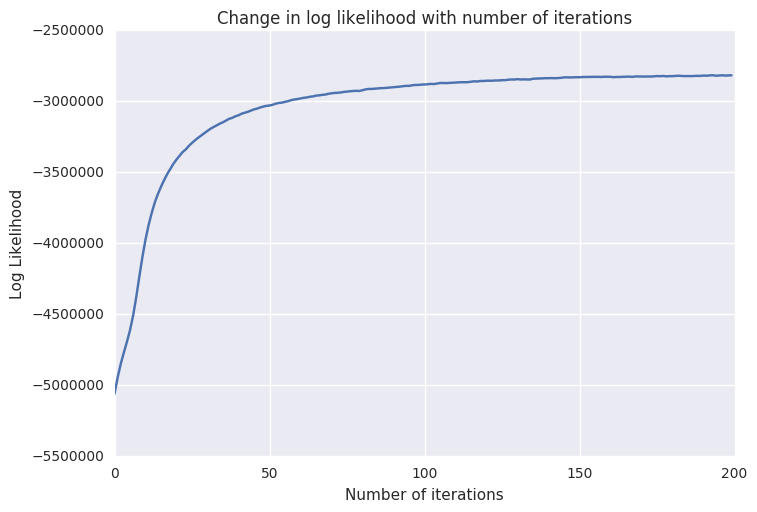

In [43]:
plt.plot(slda['model'].loglikelihoods)
plt.title('Change in log likelihood with number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Log Likelihood')

### Dividing dataset into test and train parts (10:90) and predicting GameSpot score based on review text 

In [44]:
n=len(df)
train_ratio=0.9
wordMat, features=vectorize(df['Review'])
n_train=int(n*train_ratio)
n_test=n-n_train

wordMat=wordMat.todense()
testRows=random.sample((list(df.index)), n_test)
test_df=df.ix[testRows]
train_df=df.drop(testRows)

subWordMatTest=subWordMatrix(wordMat, test_df.index)
subWordMatTest=sparse.csr_matrix(subWordMatTest, dtype='int')

subWordMatTrain=subWordMatrix(wordMat, train_df.index)
subWordMatTrain=sparse.csr_matrix(subWordMatTrain, dtype='int')

train_slda=runSLDA(train_df, subWordMatTrain, features, mu, mu2, sigma2, n_iter)

Number of inputs: 3872
2017-04-16 01:41:22.738642 start iterations
2017-04-16 01:41:37.303080 0:00:14.564438 elapsed, iter   10, LL -3584701.7448, 21.38% change from last
2017-04-16 01:41:51.047421 0:00:28.308779 elapsed, iter   20, LL -3015241.4605, 15.89% change from last
2017-04-16 01:42:05.319038 0:00:42.580396 elapsed, iter   30, LL -2832853.2247, 6.05% change from last
2017-04-16 01:42:19.099391 0:00:56.360749 elapsed, iter   40, LL -2738881.3295, 3.32% change from last
2017-04-16 01:42:32.972528 0:01:10.233886 elapsed, iter   50, LL -2674461.6006, 2.35% change from last
2017-04-16 01:42:59.409494 0:01:36.670852 elapsed, iter   60, LL -2637454.6142, 1.38% change from last
2017-04-16 01:43:24.391087 0:02:01.652445 elapsed, iter   70, LL -2610634.3272, 1.02% change from last
2017-04-16 01:43:42.300083 0:02:19.561441 elapsed, iter   80, LL -2589194.6765, 0.82% change from last
2017-04-16 01:43:56.335205 0:02:33.596563 elapsed, iter   90, LL -2570537.6788, 0.72% change from last
2017

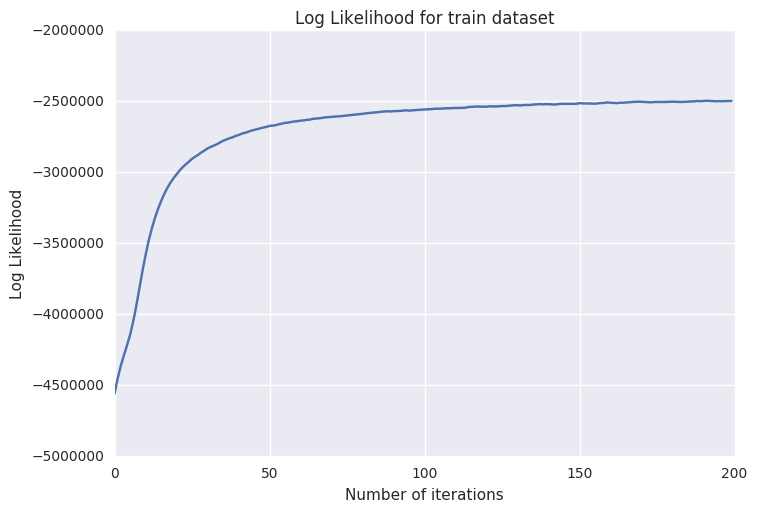

In [45]:
sampler=1
y, lglk=sldaPred(train_slda['model'], subWordMatTest, len(test_df), sampler)
plt.plot(train_slda['model'].loglikelihoods)
plt.title('Log Likelihood for train dataset')
plt.xlabel('Number of iterations')
plt.ylabel('Log Likelihood')

### Root mean square error calculation of predictions

In [48]:
rmse=calcRMSE(test_df['GameSpotScore'], y)
print(rmse)
i=0
for a, b in enumerate(y):
    game=df.iloc[a]
    print(game['Name'], 'Original Score', game['GameSpotScore'], 'Predicted Score', b)
    i+=0

2.11336850775
7 Wonders of the Ancient World Original Score 5.0 Predicted Score 6.74067597524
Advance Wars: Days of Ruin Original Score 8.0 Predicted Score 6.39831473915
Advance Wars: Dual Strike Original Score 9.2 Predicted Score 6.38331663532
Age of Empires: Mythologies Original Score 8.5 Predicted Score 6.78545217413
Age of Empires: The Age of Kings Original Score 8.2 Predicted Score 7.56724137441
Air Traffic Chaos Original Score 8.0 Predicted Score 7.22408882747
Animal Crossing: Wild World Original Score 8.4 Predicted Score 6.3668236293
Apollo Justice: Ace Attorney Original Score 7.0 Predicted Score 6.90064202298
Arkanoid DS Original Score 8.0 Predicted Score 5.75110252162
Arthur and the Invisibles Original Score 7.0 Predicted Score 5.02333149881
Art Style: AQUIA Original Score 7.0 Predicted Score 5.7790461297
Asphalt: Urban GT 2 Original Score 7.5 Predicted Score 6.96282508685
Assassin's Creed: Altair's Chronicles Original Score 6.0 Predicted Score 7.20547547008
ATV: Quad Frenzy O

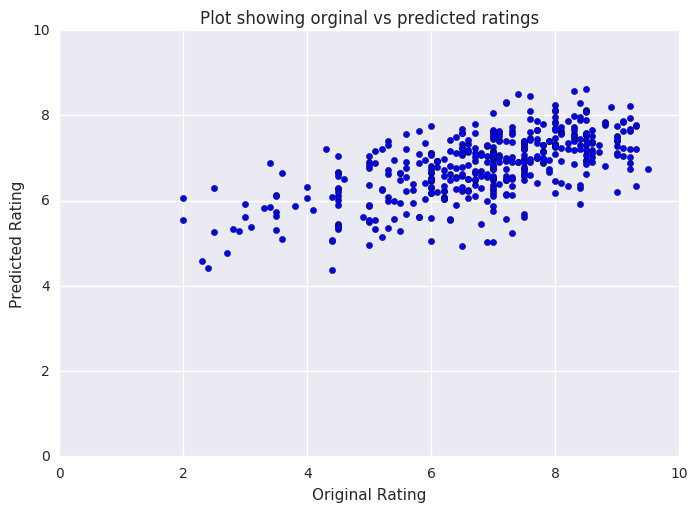

In [52]:
x_val=test_df['GameSpotScore']
y_val=y
plt.scatter(x_val, y_val)
plt.title('Plot showing orginal vs predicted ratings')
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Original Rating')
plt.ylabel('Predicted Rating')
plt.show()

### Below we plot how the log likelihood changes according to the number of samples we choose from training

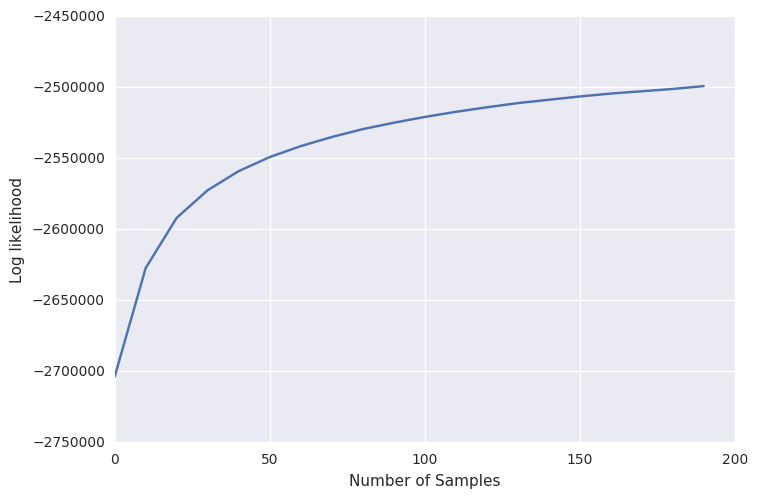

In [53]:
i=0
n_iters=200
samples=[]
lglk_=[]
while(i<n_iters):
    samples.append(i)
    i=i+10
for val in samples:
    y, lglk=sldaPred(train_slda['model'], subWordMatTest, len(test_df), val)
    lglk_.append(lglk)
plt.plot(samples, lglk_)
plt.xlabel('Number of Samples')
plt.ylabel('Log likelihood')

In [58]:
df_top=df[(df['GameSpotScore']>=7)]
df_average=df[(df['GameSpotScore']<7) & (df['GameSpotScore']>=4)]
df_bad=df[(df['GameSpotScore']<4)]

wordMat, features=vectorize(df_top['Review'])
sldaTop=runSLDA(df_top, wordMat, features, mu, mu2, sigma2, n_iter)
printTopWords(sldaTop)

Number of inputs: 2300
2017-04-16 02:07:25.007433 start iterations
2017-04-16 02:07:35.504419 0:00:10.496986 elapsed, iter   10, LL -2341663.1425, 25.49% change from last
2017-04-16 02:07:46.120215 0:00:21.112782 elapsed, iter   20, LL -1974365.8951, 15.69% change from last
2017-04-16 02:07:55.814016 0:00:30.806583 elapsed, iter   30, LL -1849897.4165, 6.30% change from last
2017-04-16 02:08:05.448049 0:00:40.440616 elapsed, iter   40, LL -1779553.5544, 3.80% change from last
2017-04-16 02:08:14.959391 0:00:49.951958 elapsed, iter   50, LL -1738163.4265, 2.33% change from last
2017-04-16 02:08:24.600256 0:00:59.592823 elapsed, iter   60, LL -1712164.0265, 1.50% change from last
2017-04-16 02:08:35.306631 0:01:10.299198 elapsed, iter   70, LL -1691153.2597, 1.23% change from last
2017-04-16 02:08:44.704621 0:01:19.697188 elapsed, iter   80, LL -1676067.6635, 0.89% change from last
2017-04-16 02:08:54.362652 0:01:29.355219 elapsed, iter   90, LL -1663210.7858, 0.77% change from last
2017

In [61]:
wordMat, features=vectorize(df_average['Review'])
slda_average=runSLDA(df_average, wordMat, features, mu, mu2, sigma2, n_iter)
printTopWords(slda_average)

Number of inputs: 1708
2017-04-16 02:24:09.188307 start iterations
2017-04-16 02:24:14.524029 0:00:05.335722 elapsed, iter   10, LL -1268157.4501, 26.26% change from last
2017-04-16 02:24:19.562947 0:00:10.374640 elapsed, iter   20, LL -1080603.8616, 14.79% change from last
2017-04-16 02:24:24.861550 0:00:15.673243 elapsed, iter   30, LL -1010456.5286, 6.49% change from last
2017-04-16 02:24:30.085149 0:00:20.896842 elapsed, iter   40, LL -974384.8103, 3.57% change from last
2017-04-16 02:24:35.597400 0:00:26.409093 elapsed, iter   50, LL -954145.8988, 2.08% change from last
2017-04-16 02:24:40.556506 0:00:31.368199 elapsed, iter   60, LL -937676.7239, 1.73% change from last
2017-04-16 02:24:45.484903 0:00:36.296596 elapsed, iter   70, LL -927750.6063, 1.06% change from last
2017-04-16 02:24:50.499661 0:00:41.311354 elapsed, iter   80, LL -919065.1872, 0.94% change from last
2017-04-16 02:24:55.465134 0:00:46.276827 elapsed, iter   90, LL -914417.2151, 0.51% change from last
2017-04-16

In [60]:
wordMat, features=vectorize(df_bad['Review'])
slda_bad=runSLDA(df_bad, wordMat, features, mu, mu2, sigma2, n_iter)
printTopWords(slda_bad)

Number of inputs: 295
2017-04-16 02:23:51.079315 start iterations
2017-04-16 02:23:51.980144 0:00:00.900829 elapsed, iter   10, LL -123357.8220, 49.15% change from last
2017-04-16 02:23:52.800988 0:00:01.721673 elapsed, iter   20, LL -101096.7860, 18.05% change from last
2017-04-16 02:23:53.484892 0:00:02.405577 elapsed, iter   30, LL -92888.0425, 8.12% change from last
2017-04-16 02:23:54.211677 0:00:03.132362 elapsed, iter   40, LL -88911.4907, 4.28% change from last
2017-04-16 02:23:54.922108 0:00:03.842793 elapsed, iter   50, LL -86926.7254, 2.23% change from last
2017-04-16 02:23:55.684471 0:00:04.605156 elapsed, iter   60, LL -84305.5694, 3.02% change from last
2017-04-16 02:23:56.448810 0:00:05.369495 elapsed, iter   70, LL -83986.4112, 0.38% change from last
2017-04-16 02:23:57.151968 0:00:06.072653 elapsed, iter   80, LL -82801.4982, 1.41% change from last
2017-04-16 02:23:57.869638 0:00:06.790323 elapsed, iter   90, LL -81398.1775, 1.69% change from last
2017-04-16 02:23:58.5